# Predict Health Outcome Horses

Based on the dataset: https://www.kaggle.com/competitions/playground-series-s3e22/overview

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

In [2]:
import so_ml_tools as soml
import tensorflow as tf
import keras as ks
import pandas as pd
import sklearn as sk
import numpy as np
import shap as sh

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

2023-11-08 12:10:33.751009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 12:10:33.751030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 12:10:33.751054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 12:10:34.326398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
TRAIN_CSV = './data/train.csv'
VALIDATION_CSV = './data/test.csv'

In [4]:
train_data = pd.read_csv(TRAIN_CSV)
validation_data = pd.read_csv(VALIDATION_CSV)

train_data.shape, validation_data.shape

((1235, 29), (824, 28))

# Get a quick look at the training data.

In [5]:
train_data.head().T

,0,1,2,3,4
id,0,1,2,3,4
surgery,yes,yes,yes,yes,no
age,adult,adult,adult,adult,adult
hospital_number,530001,533836,529812,5262541,5299629
rectal_temp,38.1,37.5,38.3,37.1,38.0
pulse,132.0,88.0,120.0,72.0,52.0
respiratory_rate,24.0,12.0,28.0,30.0,48.0
temp_of_extremities,cool,cool,cool,cold,normal
peripheral_pulse,reduced,normal,reduced,reduced,normal
mucous_membrane,dark_cyanotic,pale_cyanotic,pale_pink,pale_pink,normal_pink


In [6]:
soml.pd.dataframe.describe(dataframe=train_data)

Total number of rows: 1235


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,id,int64,1235,0,1235,617.00,356.66,-452.97,1686.97,0.0,308.5,617.0,925.5,1234.0
1,surgery,object,1235,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,age,object,1235,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hospital_number,int64,1235,0,255,954500.40,1356403.14,-3114709.02,5023709.82,521399.0,528800.0,529777.0,534145.0,5305129.0
4,rectal_temp,float64,1235,0,43,38.20,0.79,35.84,40.57,35.4,37.8,38.2,38.6,40.8
5,pulse,float64,1235,0,50,79.57,29.11,-7.75,166.90,30.0,53.0,76.0,100.0,184.0
6,respiratory_rate,float64,1235,0,37,30.05,16.45,-19.30,79.41,8.0,18.0,28.0,36.0,96.0
7,temp_of_extremities,object,1196,39,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,peripheral_pulse,object,1175,60,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,mucous_membrane,object,1214,21,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Remove possible unnecesary columns

In [7]:
soml.pd.dataframe.drop_columns(dataframe=train_data, column_names=['id', 'lesion_3', 'lesion_2', 'hospital_number'])
soml.pd.dataframe.drop_columns(dataframe=validation_data, column_names=['id', 'lesion_3', 'lesion_2', 'hospital_number'])

# Fill in empty cells with default values.

In [8]:
column_values = {
    'temp_of_extremities': 'normal',
    'peripheral_pulse': 'normal',
    'capillary_refill_time': '3',
    'pain': 'slight',
    'peristalsis': 'normal',
    'abdominal_distention': 'none',
    'nasogastric_tube': 'none',
    'nasogastric_reflux': 'none',
    'rectal_exam_feces': 'normal',
    'abdomen': 'normal',
    'abdomo_appearance': 'clear',
    'mucous_membrane': 'pale_pink'
}

# Deleting the records that have NaN values has a better effect on the training result then filling in with default values.
soml.pd.dataframe.delete_rows_where_columns_have_null_value(dataframe=train_data, inplace=True)
# soml.pd.dataframe.fill_nan_with_value(dataframe=train_data, column_values=column_values, inplace=True)

soml.pd.dataframe.fill_nan_with_value(dataframe=validation_data, column_values=column_values, inplace=True)
soml.pd.dataframe.describe(dataframe=train_data)

Total number of rows: 771


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,surgery,object,771,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,age,object,771,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rectal_temp,float64,771,0,39,38.19,0.82,35.72,40.67,35.4,37.8,38.1,38.5,40.8
3,pulse,float64,771,0,49,77.47,27.03,-3.61,158.55,30.0,52.0,72.0,96.0,184.0
4,respiratory_rate,float64,771,0,34,29.42,16.13,-18.96,77.80,8.0,18.0,24.0,36.0,96.0
5,temp_of_extremities,object,771,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,peripheral_pulse,object,771,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,mucous_membrane,object,771,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,capillary_refill_time,object,771,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,pain,object,771,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column 'surgery' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 2.
Column 'age' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 2.
Column 'surgical_lesion' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 2.
Column 'cp_data' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 2.


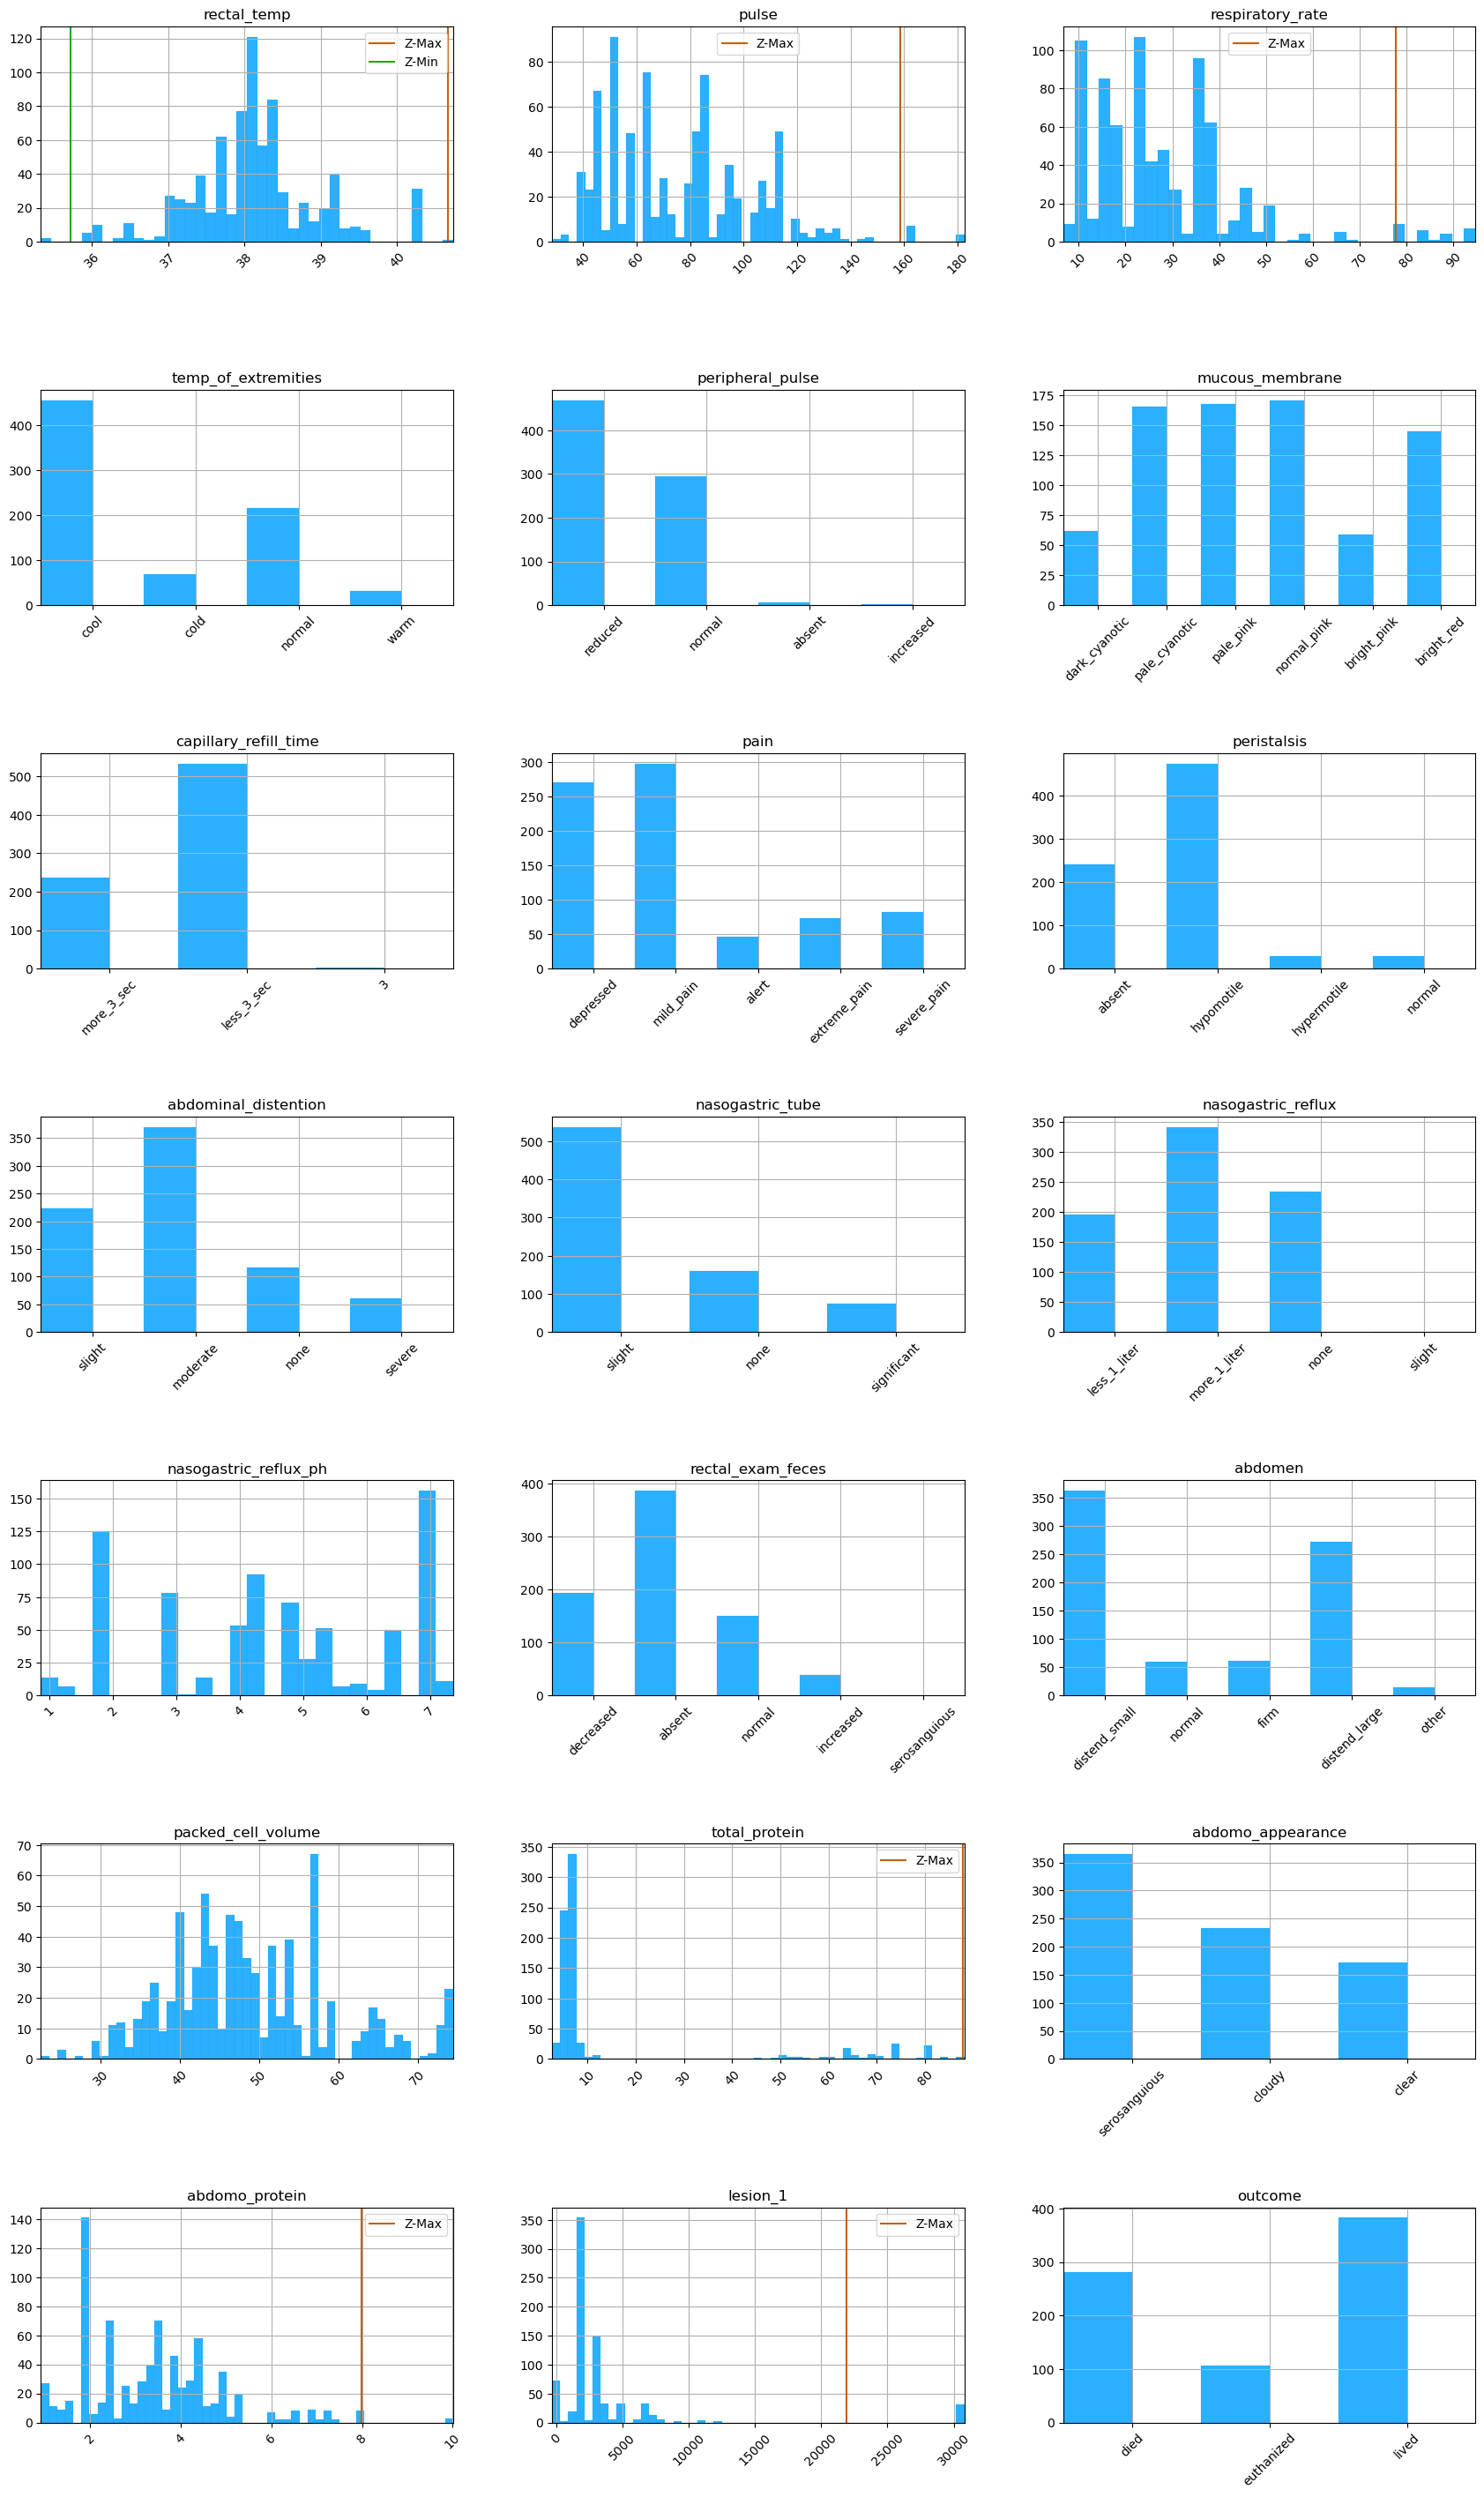

In [9]:
soml.pd.plot.histogram_for_columns(dataframe=train_data, min_nunique=2)

# Remove records

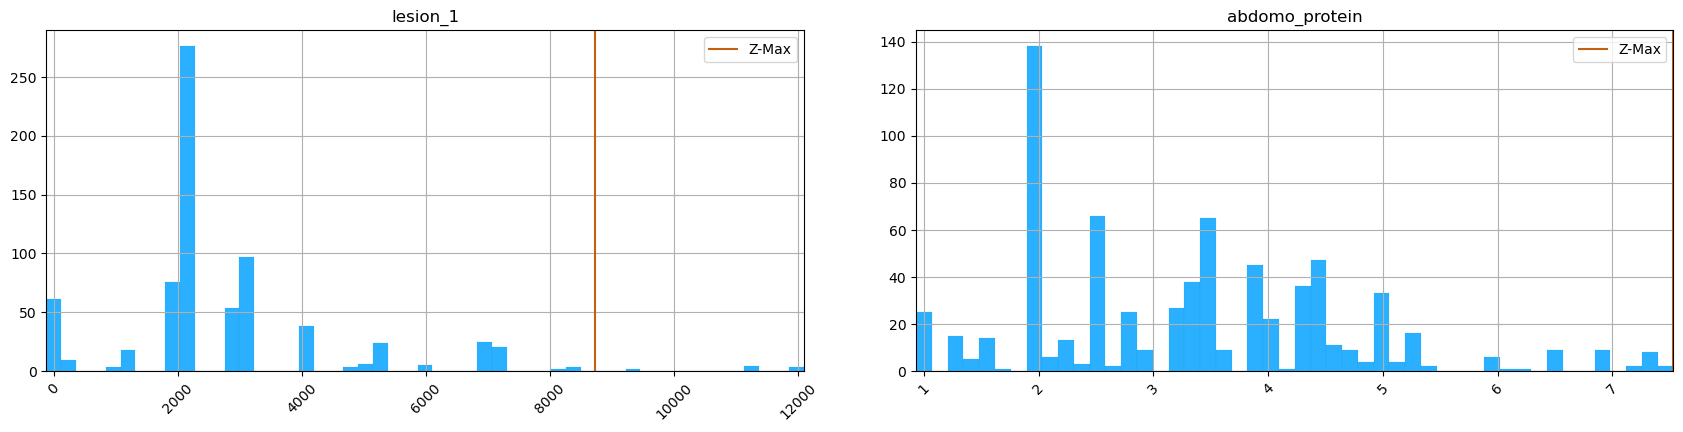

In [10]:
soml.pd.dataframe.delete_rows_where_value_greater_then_z_max(train_data, column_names=['lesion_1', 'abdomo_protein'], inplace=True)
soml.pd.plot.histogram_for_columns(dataframe=train_data, column_names=['lesion_1', 'abdomo_protein'])

# Create column transformer

In [11]:
set_config(transform_output="default")
ct = make_column_transformer(
    (sk.preprocessing.OrdinalEncoder(categories=[["no", "yes"]]), ["surgery"]),
    # (sk.preprocessing.OrdinalEncoder(categories=[["young", "adult"]]), ["age"]),
    (sk.preprocessing.StandardScaler(), ["rectal_temp"]),
    (sk.preprocessing.StandardScaler(), ["pulse"]),
    (sk.preprocessing.StandardScaler(), ["respiratory_rate"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["cold", "cool", "normal", "warm"]]), ["temp_of_extremities"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["absent", "reduced", "normal", "increased"]]), ["peripheral_pulse"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["dark_cyanotic", "pale_cyanotic", "pale_pink", "normal_pink", "bright_pink", "bright_red"]]), ["mucous_membrane"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["less_3_sec", "3", "more_3_sec"]]), ["capillary_refill_time"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["depressed", "alert", "slight", "moderate", "mild_pain", "severe_pain", "extreme_pain"]]), ["pain"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["absent", "hypomotile", "normal", "distend_small", "hypermotile"]]), ["peristalsis"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["none", "slight", "moderate", "severe"]]), ["abdominal_distention"]),
    # (sk.preprocessing.OrdinalEncoder(categories=[["none", "slight", "significant"]]), ["nasogastric_tube"]),
    # (sk.preprocessing.OrdinalEncoder(categories=[["less_1_liter", "slight", "none", "more_1_liter"]]), ["nasogastric_reflux"]),
    (sk.preprocessing.StandardScaler(), ["nasogastric_reflux_ph"]),
    # (sk.preprocessing.OrdinalEncoder(categories=[["normal", "absent", "decreased", "increased", "serosanguious"]]), ["rectal_exam_feces"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["distend_small", "normal", "other", "distend_large", "firm"]]), ["abdomen"]),
    (sk.preprocessing.StandardScaler(), ["packed_cell_volume"]),
    (sk.preprocessing.StandardScaler(), ["total_protein"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["clear", "cloudy", "serosanguious"]]), ["abdomo_appearance"]),
    (sk.preprocessing.StandardScaler(), ["abdomo_protein"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["no", "yes"]]), ["surgical_lesion"]),
    # (sk.preprocessing.MinMaxScaler(), ["lesion_1"]),
    (sk.preprocessing.OrdinalEncoder(categories=[["no", "yes"]]), ["cp_data"]),
)
ct.fit(train_data)

ColumnTransformer(transformers=[('ordinalencoder-1',
                                 OrdinalEncoder(categories=[['no', 'yes']]),
                                 ['surgery']),
                                ('standardscaler-1', StandardScaler(),
                                 ['rectal_temp']),
                                ('standardscaler-2', StandardScaler(),
                                 ['pulse']),
                                ('standardscaler-3', StandardScaler(),
                                 ['respiratory_rate']),
                                ('ordinalencoder-2',
                                 OrdinalEncoder(categories=[['cold', 'cool',
                                                             'normal',
                                                             'warm']]),
                                 [...
                                ('standardscaler-6', StandardScaler(),
                                 ['total_protein']),
                                ('ordinalencoder-10',
                                 OrdinalEncoder(categories=[['clear', 'cloudy',
                                                             'serosanguious']]),
                                 ['abdomo_appearance']),
                                ('standardscaler-7', StandardScaler(),
                                 ['abdomo_protein']),
                                ('ordinalencoder-11',
                                 OrdinalEncoder(categories=[['no', 'yes']]),
                                 ['surgical_lesion']),
                                ('ordinalencoder-12',
                                 OrdinalEncoder(categories=[['no', 'yes']]),
                                 ['cp_data'])])

# Split data into train / test and create the label values.

In [12]:
# Split training into train / test
train_x, test_x = soml.data.split.split_train_test_data(train_data, shuffle=False)

# Get the labels for training
train_y = train_x['outcome'].to_numpy().reshape(-1, 1)
outcome_encoder = sk.preprocessing.OneHotEncoder(sparse_output=False)
outcome_encoder.fit(train_y)
train_y_one_hot = outcome_encoder.transform(train_y)

# Get the labels for testing
test_y = test_x['outcome'].to_numpy().reshape(-1, 1)
test_y_one_hot = outcome_encoder.transform(test_y)

# Get the class names
class_names = outcome_encoder.categories_

# Transform training
train_x = ct.transform(train_x)
train_x_pd = pd.DataFrame(train_x, columns=ct.get_feature_names_out())

# Transform testing
test_x = ct.transform(test_x)
test_x_pd = pd.DataFrame(test_x, columns=ct.get_feature_names_out())

# Transform validation
validation_data_transformed = ct.transform(validation_data)
validation_data_transformed_pd = pd.DataFrame(validation_data_transformed, columns=ct.get_feature_names_out())

# Check dimensions

In [13]:
train_x.shape, train_y_one_hot.shape, test_x.shape, test_y_one_hot.shape

((583, 19), (583, 3), (146, 19), (146, 3))

In [14]:
train_x_pd.head().T

,0,1,2,3,4
ordinalencoder-1__surgery,1.000000,1.000000,1.000000,0.000000,0.000000
standardscaler-1__rectal_temp,-0.101943,-0.816523,-1.292910,-0.221040,-0.101943
standardscaler-2__pulse,2.008213,0.384226,-0.206315,-0.944491,-0.796855
standardscaler-3__respiratory_rate,-0.343530,-1.088684,0.029046,1.146777,0.153239
ordinalencoder-2__temp_of_extremities,1.000000,1.000000,0.000000,2.000000,2.000000
ordinalencoder-3__peripheral_pulse,1.000000,2.000000,1.000000,2.000000,2.000000
ordinalencoder-4__mucous_membrane,0.000000,1.000000,2.000000,3.000000,4.000000
ordinalencoder-5__capillary_refill_time,2.000000,2.000000,2.000000,0.000000,0.000000
ordinalencoder-6__pain,0.000000,4.000000,4.000000,1.000000,0.000000
ordinalencoder-7__peristalsis,0.000000,0.000000,1.000000,1.000000,1.000000


# Build the initial base-model

In [15]:
input_layer = ks.layers.Input(shape=(train_x.shape[1]))
x = ks.layers.Dense(units=32, activation="relu")(input_layer)
x = ks.layers.Dropout(rate=0.2)(x)
x = ks.layers.Dense(units=32, activation="relu")(x)
x = ks.layers.Dropout(rate=0.2)(x)
x = ks.layers.Dense(units=32, activation="relu")(x)
output_layer = ks.layers.Dense(units=3)(x)

base_model = ks.Model(inputs=input_layer, outputs=output_layer)
base_model.compile(loss=ks.losses.CategoricalCrossentropy(from_logits=True),
                   optimizer=ks.optimizers.Adam(),
                   metrics=["accuracy"])
soml.tf.model.inspect.list_model(model=base_model)

row   | name (type)            | dtype   | policy  | trainable | output shape | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_1   (InputLayer) | float32 | float32 | True      | [(None, 19)] | 0             | 0                 | 0                    
1     | dense     (Dense     ) | float32 | float32 | True      | (None, 32)   | 640           | 640               | 0                    
2     | dropout   (Dropout   ) | float32 | float32 | True      | (None, 32)   | 0             | 0                 | 0                    
3     | dense_1   (Dense     ) | float32 | float32 | True      | (None, 32)   | 1,056         | 1,056             | 0                    
4     | dropout_1 (Dropout   ) | float32 | float32 | True      | (None, 32)   | 0             | 0                 | 0                    
5     | dense_2   (Dense     ) | float32 | float32 | True      | (None, 32)   | 1,056         | 1,056             | 0                    
6     | dense_3   (Dense     ) | f

2023-11-08 10:54:10.034239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [16]:
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback()

history_base_model = base_model.fit(
    x=train_x, 
    batch_size=32,    
    y=train_y_one_hot, 
    epochs=100, 
    validation_data=(test_x, test_y_one_hot),
    callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback])

Epoch 1/100
19/19 [==============================] - 1s 6ms/step - loss: 1.1400 - accuracy: 0.3928 - val_loss: 0.9648 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 0s 1ms/step - loss: 0.9929 - accuracy: 0.4820 - val_loss: 0.9131 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 0s 1ms/step - loss: 0.9515 - accuracy: 0.5506 - val_loss: 0.8826 - val_accuracy: 0.6096 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 0s 1ms/step - loss: 0.8986 - accuracy: 0.5780 - val_loss: 0.8451 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 0s 1ms/step - loss: 0.8722 - accuracy: 0.5849 - val_loss: 0.8378 - val_accuracy: 0.7055 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - 0s 1ms/step - loss: 0.8427 - accuracy: 0.6226 - val_loss: 0.8340 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 7/100
19/19 [==============================] - 0s 1ms/step - loss: 0.8

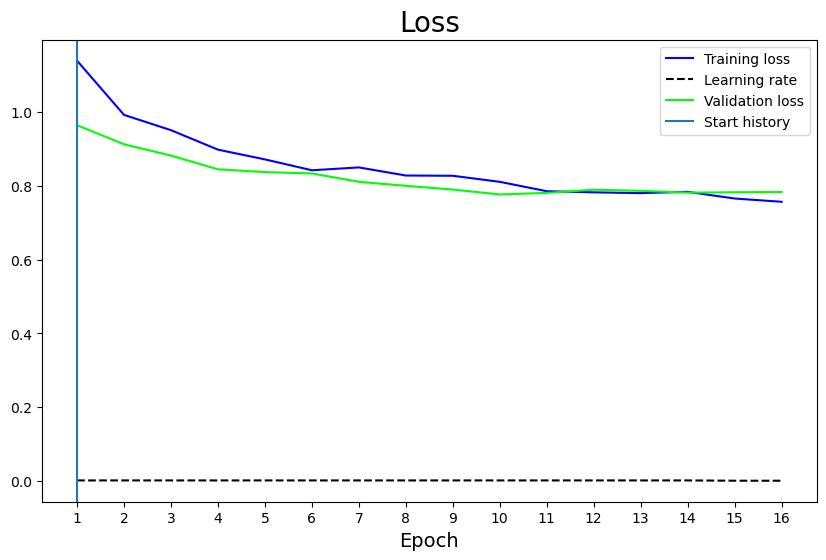

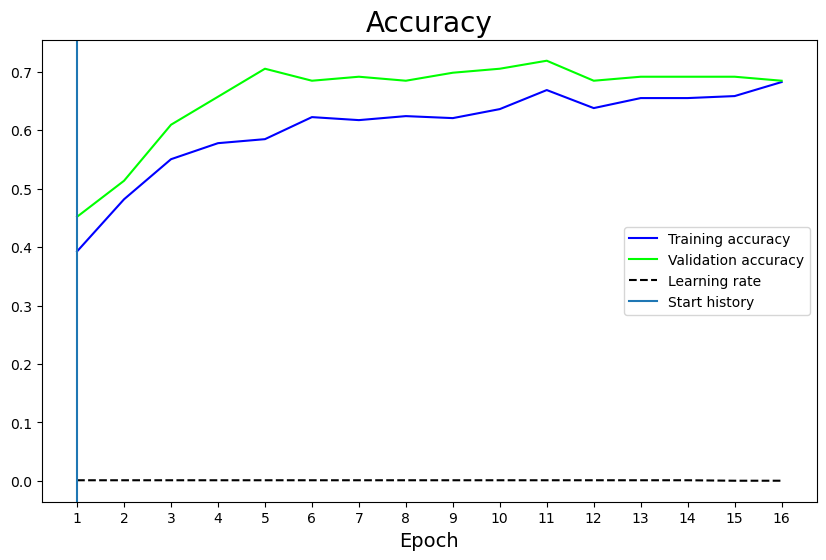

In [17]:
soml.tf.model.plot.plot_history(history=history_base_model)

# Validate the model

In [18]:
base_model.evaluate(test_x, test_y_one_hot)

5/5 [==============================] - 0s 679us/step - loss: 0.7771 - accuracy: 0.7055


[0.7770673632621765, 0.7054794430732727]

In [19]:
y_prob = base_model.predict(x=test_x)

5/5 [==============================] - 0s 530us/step


In [20]:
soml.evaluate.analyze.quality_metrics(y_true=test_y_one_hot, y_prob=y_prob)

,accuracy,f1-score,precision,recall
0,70.547945,0.700892,0.706428,0.705479


In [21]:
base_model.predict(x=train_x[:1, :])

1/1 [==============================] - 0s 9ms/step


array([[1.3652129, 0.120654 , 0.1969455]], dtype=float32)

In [22]:
sh.initjs()

In [23]:
kernel_explainer = soml.shap.report.create_kernel_explainer(model=base_model.predict, x=train_x, sample_size=200)
shap_values = soml.shap.report.calculate_shap_values(explainer=kernel_explainer, x=train_x[1, :])

7/7 [==============================] - 0s 537us/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Calculating shap values for 19 entries.
13038/13038 [==============================] - 4s 302us/step


In [24]:
soml.shap.report.force_plot(shap_values, explainer=kernel_explainer, feature_names=ct.get_feature_names_out(), display_class=0)

Overriding plot_type with 'bar' since we have multiple classes.


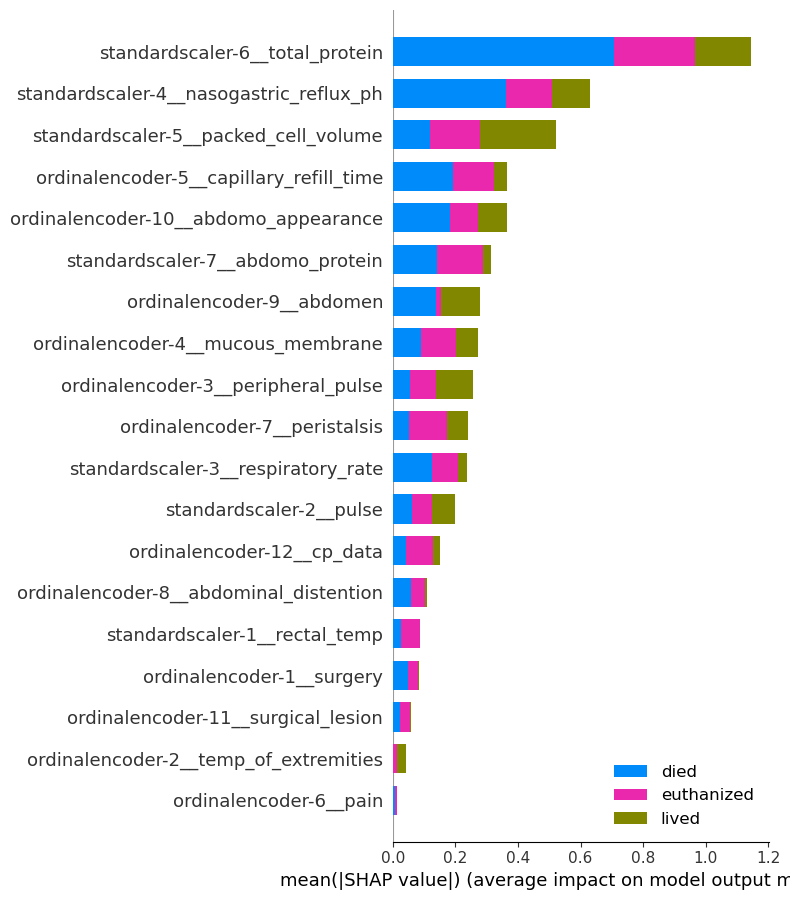

In [25]:
soml.shap.report.summary_plot(shap_values, class_names=class_names[0], feature_names = ct.get_feature_names_out(), display_entry=None, display_class=None)